# 02 Regression with PyTorch 
## Introduction
In this exercise, we fit a neural network model to 1D data.

We shall use the model 

$$f(\mathbf{x}, \theta) = \mbox{identity}(\color{blue}{\,b_1 + \mathbf{w}_1} \, \mbox{relu}(\color{red}{\mathbf{b}_0 + \mathbf{w}_0} \, \mathbf{x}) \,),$$

where $\mathbf{b}$ and $\mathbf{w}$ (the biases and weights) are the parameters $\theta$ of the model and $\mbox{relu}(x)$ is a function applied to every element $x_i$ of its tensor argument (i.e., applied element-wise) defined by

\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise},
\end{cases}
\end{align*}

and $\mbox{identity}(x) = x$.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

#  a function to save results
import joblib as jb

# pytorch
import torch

# pytorch
import torch.nn as nn

#  split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

%matplotlib inline

In [2]:
mp.__version__

'3.3.1'

In [3]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load data

In [4]:
data = jb.load('data_02.db')
data[:10]

,target,x
0,-1.401545,-0.381591
1,-2.222218,0.345640
2,0.806753,-0.891427
3,-1.225608,0.710987
4,-0.615563,-0.524796
5,-1.536294,-0.550748
6,-1.435041,0.506305
7,-1.108758,0.435569
8,-1.902575,-0.360290
9,-1.959954,-0.357140


### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [5]:
# Fraction of the data assigned as test data
fraction = 0.20
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 0.125
train_data, valid_data = train_test_split(train_data, test_size=fraction)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:         42000
validation set size:     6000
test set size:          12000


Split data into targets $t$ and inputs $\mathbf{x}$

In [6]:
def split_t_x(df):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df['target'])
    x = np.array(df['x'])
    return (t, x)

train_t, train_x = split_t_x(train_data)
valid_t, valid_x = split_t_x(valid_data)
test_t,  test_x  = split_t_x(test_data)

### Return a (random) batch of data from the training set

In [7]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined as

\begin{align}
R_M(\theta) & = \frac{1}{M}\sum_{m=1}^M L(t_m, f_m),
\end{align}

where 

\begin{align}
    f_m & \equiv f(\mathbf{x}_m, \theta),\\ \\ \textrm{and} \\
    L(t, f) &= (t - f)^2
\end{align}

The empirical risk $R_M$ approximates the __risk__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x},
\end{align}

which is a __functional__ of the model $f$. The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

In [8]:
def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

### Function to execute training loop

Note, here we use $t$ and $y$ interchangeably to denote the targets

In [9]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, step=10):
    
    xx   = []
    yy_t = []
    yy_v = []
    n    = 5000
    
    # set mode to training so that training specific operations such 
    # as dropout are enabled.
    model.train()
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # Get a random sample (a batch) of images (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # Convert the numpy arrays batch_x and batch_t, to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients wrt. x and y
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. we can do this with the reshape method.
        outputs = model(x.view(-1,1)).reshape(t.shape)

        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # Finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            acc_t = validate(model, train_x[:n], train_t[:n]) 
            acc_v = validate(model, valid_x[:n], valid_t[:n])
            
            print("\r%10d\t%10.6f\t%10.6f" % (ii, acc_t, acc_v), end='')
        
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

In [10]:
def validate(model, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x.view(-1, 1)).reshape(t.shape)
    return average_loss(o, t)

matplotlib has two graphics systems: 1) function-based and 2) object-based. The function below (plot_accuracy) illustrates the function-based system, while plot_empirical_risk illustrates the object-based system.

In [11]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss function")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

### Define model $f(\mathbf{x}, \theta)$

In [23]:
# Instead of create our own class, let's just use the Sequential class.
# Try to guess what's going on here.
N_INPUTS = 1
N_OUTPUTS= 1
model = nn.Sequential(nn.Linear(N_INPUTS, 50), nn.ReLU(),
                      nn.Linear(50, N_OUTPUTS)
     )

print (model)

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)


### Train!

Instantiate an optimizer, then train

In [19]:
n_batch       = 100
n_iterations  = 10001
learning_rate = 1.e-2
decay_rate    = 1.e-5  # rate at which to decrease learning_rate
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate, 
                                 weight_decay=decay_rate)

traces = train(model, optimizer, 
               average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               step=10)

Iteration vs average loss
 iteration	 train-set	 valid-set
     10000	  0.007376	  0.007983

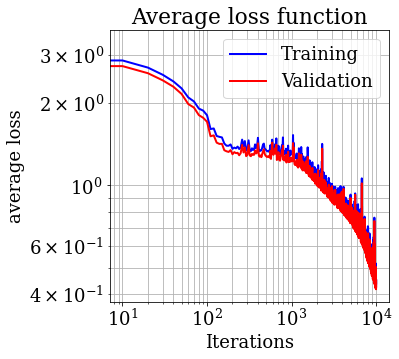

In [14]:
plot_average_loss(traces)

In [20]:
def plot_1d(x, y, xx, yy):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.scatter(x, y, c='k', s=0.5)
    ax.plot(xx, yy, c='r')
    ax.set_xlabel('$x$', fontsize=FONTSIZE)

    plt.show()

In [21]:
xx = torch.Tensor(np.arange(-1, 1, 0.01))
yy = model(xx.view(-1,1))
xx = xx.detach().numpy()
yy = yy.detach().numpy()

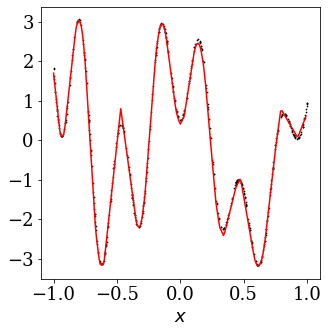

In [22]:
M = 500
plot_1d(data.x[:M], data.target[:M], xx, yy)